In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
from sklearn.preprocessing import LabelBinarizer #atribui array
from sklearn.preprocessing import LabelEncoder #atribui numeros
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import HistGradientBoostingClassifier
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from skopt import BayesSearchCV
from scipy.stats import randint
from skopt.space import Real, Integer, Categorical

In [2]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd

def validacao_cruzada(modelo, x, y, oversampling=False):
    # Inicializar o StratifiedKFold
    kfold = StratifiedKFold(n_splits=3)
    acuracias_split = []
    f1_scores_split = []

    for idx, (idx_treino, idx_validacao) in enumerate(kfold.split(x, y)):
        x_split_treino = x.iloc[idx_treino]
        y_split_treino = y.iloc[idx_treino].values.ravel()  # Converter para array unidimensional
        x_split_validacao = x.iloc[idx_validacao]
        y_split_validacao = y.iloc[idx_validacao].values.ravel()  # Converter para array unidimensional

        if oversampling:
            sm = SMOTE(random_state=42, k_neighbors=1)
            x_split_treino, y_split_treino = sm.fit_resample(x_split_treino, y_split_treino)

        # Treinar o modelo
        modelo.fit(x_split_treino, y_split_treino)
        predicoes_validacao = modelo.predict(x_split_validacao)

    
        # Calcular a acurácia e F1-score
        acuracia_split = accuracy_score(y_split_validacao, predicoes_validacao)
        f1_split = f1_score(y_split_validacao, predicoes_validacao, average='weighted')

        # Adicionar as métricas à lista
        acuracias_split.append(acuracia_split)
        f1_scores_split.append(f1_split)

        # Imprimir a acurácia do split atual
        print(f"Acurácia do split {idx + 1}: {acuracia_split:.4f}")
        print(f"F1-score do split {idx + 1}: {f1_split:.4f}")

        # Imprimir matriz de confusão e relatório de classificação
        print("Matriz de Confusão:")
        print(confusion_matrix(y_split_validacao, predicoes_validacao))
        print("\nRelatório de Classificação:")
        print(classification_report(y_split_validacao, predicoes_validacao))

        # Imprimir quantidade de amostras por classe
        print("Distribuição das classes no conjunto de treino:")
        print(pd.Series(y_split_treino).value_counts())
        print("Distribuição das classes no conjunto de validação:")
        print(pd.Series(y_split_validacao).value_counts())
        
    return acuracias_split, f1_scores_split


In [3]:
#modelo = SVC()
#modelo =  KNeighborsClassifier()
modelo = RandomForestClassifier()
#modelo = HistGradientBoostingClassifier()

In [4]:
regiao = '1'
#regiao = '2'
#regiao = '3'

In [5]:
# Definindo o diretório onde estão os arquivos de espectros Raman
diretorio_raiz = 'c:/Users/Andreia/Jupyter/TCC/elementos/R' + regiao 

# Listar os diretórios (tipos de plástico)
diretorios_plasticos = [diretorio for diretorio in os.listdir(diretorio_raiz) if os.path.isdir(os.path.join(diretorio_raiz, diretorio))]

# Inicializar listas para armazenar todos os dados e rótulos
all_data = []
all_labels = []

# Para cada tipo de plástico
for idx, plastico in enumerate(diretorios_plasticos):
    diretorio_plastico = os.path.join(diretorio_raiz, plastico)
    arquivos_plastico = os.listdir(diretorio_plastico)
    
    # Inicializar listas para armazenar dados de cada tipo de plástico
    folder_data = []
    folder_labels = []
    
    # Para cada arquivo de espectro Raman
    for arquivo in arquivos_plastico:
        # Lendo o arquivo de espectro Raman
        caminho_arquivo = os.path.join(diretorio_plastico, arquivo)
      
        # Carregando os dados do arquivo
        espectro = np.loadtxt(caminho_arquivo, delimiter='\t', dtype='str')
        
        # Adicionar espectro e rótulo às listas
        folder_data.append(espectro)
        folder_labels.append(plastico)
    
    # Adicionar dados e rótulos deste tipo de plástico às listas totais
    all_data.extend(folder_data)
    all_labels.extend(folder_labels)

# Dividir os dados totais em treino e teste
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.3, random_state=42, stratify=all_labels)


# Transformar os dados em arrays numpy
train_data = np.array(X_train)
train_labels = np.array(y_train)
test_data = np.array(X_test)
test_labels = np.array(y_test)

# Verificar a forma original dos dados
print("Forma original dos dados de treinamento:", train_data.shape)
print("Forma original dos dados de teste:", test_data.shape)

# Extrair comprimentos de onda e intensidades
train_data_reshaped = train_data[:, :, 1]
test_data_reshaped = test_data[:, :, 1]


# Verificar a forma dos dados ajustados
print("Forma ajustada dos dados de treinamento:", train_data.shape)

# Inicializar o codificador de rótulos
label_encoder = LabelEncoder()

# Ajustar o codificador aos rótulos de treino e transformá-los em valores numéricos
y_encoded_train = label_encoder.fit_transform(train_labels)

# Transformar os rótulos de teste usando o mesmo codificador
y_encoded_test = label_encoder.transform(test_labels)

# Converter os arrays numpy em DataFrames
train_data = pd.DataFrame(train_data_reshaped)
train_labels = pd.DataFrame(y_encoded_train, columns=["Label"])
test_data = pd.DataFrame(test_data_reshaped)
test_labels = pd.DataFrame(y_encoded_test, columns=["Label"])

# Verificar a forma final dos DataFrames
print("Forma final dos dados de treinamento (DataFrame):", train_data.shape)
print("Forma final dos rótulos de treinamento (DataFrame):", train_labels.shape)
print("Forma final dos dados de teste (DataFrame):", test_data.shape)
print("Forma final dos rótulos de teste (DataFrame):", test_labels.shape)

# Mostrar o valor de cada número e o significado dele
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("\nMapeamento de cada número codificado para a classe original:")
for encoded_value, original_class in class_mapping.items():
    print(f"{encoded_value}: {original_class}")

Forma original dos dados de treinamento: (942, 521, 2)
Forma original dos dados de teste: (404, 521, 2)
Forma ajustada dos dados de treinamento: (942, 521, 2)
Forma final dos dados de treinamento (DataFrame): (942, 521)
Forma final dos rótulos de treinamento (DataFrame): (942, 1)
Forma final dos dados de teste (DataFrame): (404, 521)
Forma final dos rótulos de teste (DataFrame): (404, 1)

Mapeamento de cada número codificado para a classe original:
0: ABS
1: PA
2: PC
3: PE
4: PES
5: PET
6: PMMA
7: PP
8: PS
9: PTFE
10: PU
11: PVC


In [9]:
# Verificar a distribuição dos rótulos
print("Distribuição dos rótulos no conjunto de treinamento:")
print(pd.Series(y_train).value_counts())

print("\nDistribuição dos rótulos no conjunto de teste:")
print(pd.Series(y_test).value_counts())

Distribuição dos rótulos no conjunto de treinamento:
PE      188
PS      169
PVC     163
PMMA    152
PTFE    141
PP       43
PA       25
PC       22
PES      15
ABS       9
PU        8
PET       7
Name: count, dtype: int64

Distribuição dos rótulos no conjunto de teste:
PE      80
PS      73
PVC     70
PMMA    65
PTFE    60
PP      18
PA      10
PC      10
PES      7
ABS      4
PU       4
PET      3
Name: count, dtype: int64


In [6]:
# Para a plotagem, vamos reduzir dimensionalidade com PCA ou TSNE para 2D
from sklearn.decomposition import PCA

# Reduzir dimensionalidade dos dados de treinamento
pca = PCA(n_components=20)
train_data_pca = pca.fit_transform(train_data_reshaped)
test_data_pca = pca.transform(test_data_reshaped)

# Converter os arrays numpy em DataFrames
train_data_pca = pd.DataFrame(train_data_pca)
test_data_pca = pd.DataFrame(test_data_pca )


print(sum(pca.explained_variance_ratio_))



0.9916374003844123


c:\Users\Andreia\anaconda3\Lib\site-packages\sklearn\base.py:1151: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


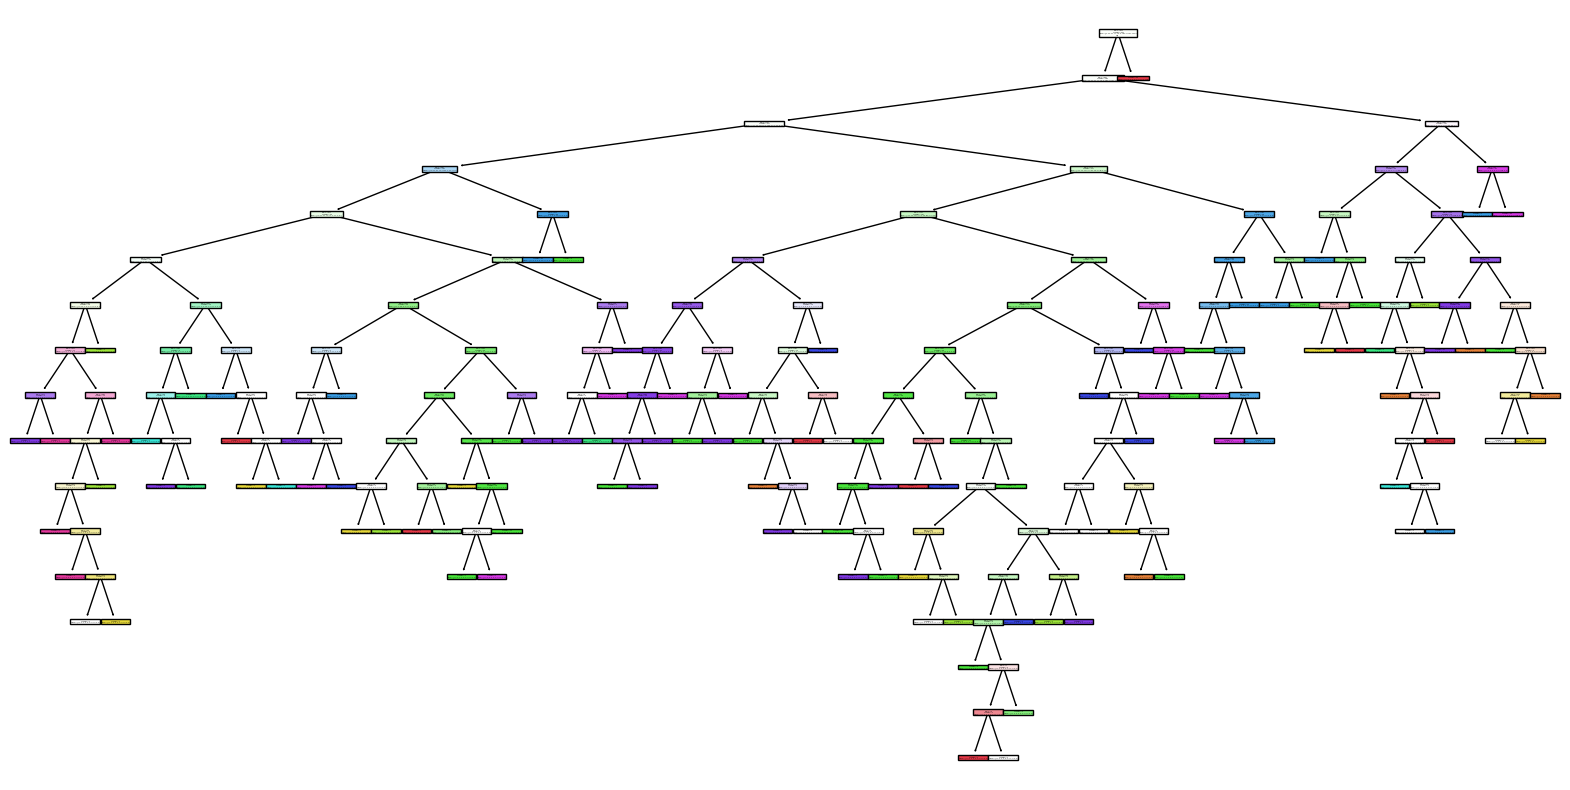

In [19]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

# Crie um RandomForestClassifier
modelo = RandomForestClassifier(n_estimators=10, random_state=42)

# Ajuste o modelo aos dados
modelo.fit(train_data_pca, train_labels)

# Acesse o primeiro estimador da floresta
tree = modelo.estimators_[0]

# Crie uma lista de nomes de características (se necessário)
feature_names = [f'PC{i}' for i in range(train_data_pca.shape[1])]

# Plote a árvore
plt.figure(figsize=(20,10))
plot_tree(tree, feature_names=feature_names, filled=True)
plt.show()


In [7]:
#regiao = '1'
#regiao = '2'
regiao = '3'

In [8]:
# Definindo o diretório onde estão os arquivos de espectros Raman
diretorio_raiz = 'c:/Users/Andreia/Jupyter/TCC/elementos/R' + regiao 

# Listar os diretórios (tipos de plástico)
diretorios_plasticos = [diretorio for diretorio in os.listdir(diretorio_raiz) if os.path.isdir(os.path.join(diretorio_raiz, diretorio))]

# Inicializar listas para armazenar todos os dados e rótulos
all_data = []
all_labels = []

# Para cada tipo de plástico
for idx, plastico in enumerate(diretorios_plasticos):
    diretorio_plastico = os.path.join(diretorio_raiz, plastico)
    arquivos_plastico = os.listdir(diretorio_plastico)
    
    # Inicializar listas para armazenar dados de cada tipo de plástico
    folder_data = []
    folder_labels = []
    
    # Para cada arquivo de espectro Raman
    for arquivo in arquivos_plastico:
        # Lendo o arquivo de espectro Raman
        caminho_arquivo = os.path.join(diretorio_plastico, arquivo)
      
        # Carregando os dados do arquivo
        espectro = np.loadtxt(caminho_arquivo, delimiter='\t', dtype='str')
        
        # Adicionar espectro e rótulo às listas
        folder_data.append(espectro)
        folder_labels.append(plastico)
    
    # Adicionar dados e rótulos deste tipo de plástico às listas totais
    all_data.extend(folder_data)
    all_labels.extend(folder_labels)

# Dividir os dados totais em treino e teste
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.3, random_state=42, stratify=all_labels)


# Transformar os dados em arrays numpy
train_data = np.array(X_train)
train_labels = np.array(y_train)
test_data = np.array(X_test)
test_labels = np.array(y_test)

# Verificar a forma original dos dados
print("Forma original dos dados de treinamento:", train_data.shape)
print("Forma original dos dados de teste:", test_data.shape)

# Extrair comprimentos de onda e intensidades
train_data_reshaped = train_data[:, :, 1]
test_data_reshaped = test_data[:, :, 1]


# Verificar a forma dos dados ajustados
print("Forma ajustada dos dados de treinamento:", train_data.shape)

# Inicializar o codificador de rótulos
label_encoder = LabelEncoder()

# Ajustar o codificador aos rótulos de treino e transformá-los em valores numéricos
y_encoded_train = label_encoder.fit_transform(train_labels)

# Transformar os rótulos de teste usando o mesmo codificador
y_encoded_test = label_encoder.transform(test_labels)

# Converter os arrays numpy em DataFrames
train_data3 = pd.DataFrame(train_data_reshaped)
train_labels3 = pd.DataFrame(y_encoded_train, columns=["Label"])
test_data3 = pd.DataFrame(test_data_reshaped)
test_labels3 = pd.DataFrame(y_encoded_test, columns=["Label"])

# Verificar a forma final dos DataFrames
print("Forma final dos dados de treinamento (DataFrame):", train_data.shape)
print("Forma final dos rótulos de treinamento (DataFrame):", train_labels.shape)
print("Forma final dos dados de teste (DataFrame):", test_data.shape)
print("Forma final dos rótulos de teste (DataFrame):", test_labels.shape)

# Mostrar o valor de cada número e o significado dele
class_mapping = {index: label for index, label in enumerate(label_encoder.classes_)}
print("\nMapeamento de cada número codificado para a classe original:")
for encoded_value, original_class in class_mapping.items():
    print(f"{encoded_value}: {original_class}")

Forma original dos dados de treinamento: (187, 1700, 2)
Forma original dos dados de teste: (81, 1700, 2)
Forma ajustada dos dados de treinamento: (187, 1700, 2)
Forma final dos dados de treinamento (DataFrame): (187, 1700, 2)
Forma final dos rótulos de treinamento (DataFrame): (187,)
Forma final dos dados de teste (DataFrame): (81, 1700, 2)
Forma final dos rótulos de teste (DataFrame): (81,)

Mapeamento de cada número codificado para a classe original:
0: ABS
1: PA
2: PC
3: PE
4: PES
5: PET
6: PMMA
7: PP
8: PS
9: PTFE
10: PU
11: PVC


In [9]:
# Para a plotagem, vamos reduzir dimensionalidade com PCA ou TSNE para 2D
from sklearn.decomposition import PCA

# Reduzir dimensionalidade dos dados de treinamento
pca = PCA(n_components=15)
train_data_pca3 = pca.fit_transform(train_data_reshaped)
test_data_pca3 = pca.transform(test_data_reshaped)


#Converter os arrays numpy em DataFrames
train_data_pca3 = pd.DataFrame(train_data_pca3)
test_data_pca3 = pd.DataFrame(test_data_pca3 )


print(sum(pca.explained_variance_ratio_))



0.9901979242653406


In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import loguniform, uniform, randint

# Definir o espaço de hiperparâmetros para o modelo base
param_dist = {
    'estimator__C': loguniform(0.1, 10),  # Distribuição log-uniforme para C
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Diferentes tipos de kernel
    'estimator__gamma': loguniform(1e-4, 1e-1),  # Distribuição log-uniforme para gamma
    'estimator__degree': randint(1, 10),  # Distribuição discreta para o grau do kernel polinomial
    'estimator__coef0': uniform(-1, 1)  # Distribuição uniforme para coef0
}


# Configurar o RandomizedSearchCV com o OneVsRestClassifier
random_search = RandomizedSearchCV(
    modelo,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Ajustar o RandomizedSearchCV com os dados de treinamento
random_search.fit(train_data_pca3, train_labels3)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros (Random Search): ", random_search.best_params_)
print("Acurácia (Random Search): ", random_search.best_score_)

Melhores hiperparâmetros (Random Search):  {'estimator__C': 8.83122824824253, 'estimator__coef0': -0.6069022753332396, 'estimator__degree': 6, 'estimator__gamma': 0.05227527945418865, 'estimator__kernel': 'rbf'}
Acurácia (Random Search):  0.6257040450588837


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from scipy.stats import loguniform, uniform, randint

# Definir o espaço de hiperparâmetros para o modelo base
param_dist = {
    'estimator__C': loguniform(0.1, 10),  # Distribuição log-uniforme para C
    'estimator__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],  # Diferentes tipos de kernel
    'estimator__gamma': loguniform(1e-4, 1e-1),  # Distribuição log-uniforme para gamma
    'estimator__degree': randint(1, 10),  # Distribuição discreta para o grau do kernel polinomial
    'estimator__coef0': uniform(-1, 1)  # Distribuição uniforme para coef0
}


# Configurar o RandomizedSearchCV com o OneVsRestClassifier
random_search = RandomizedSearchCV(
    modelo,
    param_distributions=param_dist,
    n_iter=100,
    cv=3,
    random_state=42,
    n_jobs=-1
)

# Ajustar o RandomizedSearchCV com os dados de treinamento
random_search.fit(train_data_pca, train_labels)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros (Random Search): ", random_search.best_params_)
print("Acurácia (Random Search): ", random_search.best_score_)

ValueError: Found input variables with inconsistent numbers of samples: [942, 187]

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier



# Definir o espaço de hiperparâmetros para a busca
param_grid = {
    'n_estimators': list(range(10, 201)),  # Número de árvores (de 10 a 200)
    'criterion': ['gini', 'entropy'],  # Função de critério
    'max_depth': list(range(1, 21)),  # Profundidade máxima (de 1 a 20)
    'min_samples_split': list(range(2, 21)),  # Número mínimo de amostras para dividir (de 2 a 20)
    'min_samples_leaf': list(range(1, 21))  # Número mínimo de amostras para folha (de 1 a 20)
}

# Configurar o GridSearchCV
grid_search = GridSearchCV(
    modelo,
    param_grid=param_grid,
    cv=2,
    n_jobs=-1
)

# Ajustar o GridSearchCV com os dados de treinamento
grid_search.fit(train_data_pca3, train_labels3)

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros (Grid Search): ", grid_search.best_params_)
print("Acurácia (Grid Search): ", grid_search.best_score_)


KeyboardInterrupt: 